# Gif of Flights
The goal of this post is to visualize flights taken from Google location data using Python
* will create a .gif progressing through individual flights and a .png of all flights
* see [Location Data Exploration #1 post](http://kivanpolimis.com/location-data-exploration-1.html) for instructions to complete the first step (Setup):
    + download location data from Google Takeout 
    + install the relevant modules to complete this analysis on your own
* This post utilizes code from Tyler Hartley's [visualizing location history blog post](http://beneathdata.com/how-to/visualizing-my-location-history/) 


# Overview 

1. Setup
    * download data
    * install modules
2. Data Wrangling
    * data extraction
    * data exploration
    * data manipulation
3. Flight Algorithm
4. Visualize Flights
    * create individual .png of each flight to combine into .gif
    * create .png of all flights plotted at once
5. Conclusion

In [1]:
import os
import glob
import json
import time
import fiona
import datetime
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from shapely.prepared import prep
from descartes import PolygonPatch
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
warnings.filterwarnings('ignore')

# Data Wrangling
* data extraction

In [2]:
with open('LocationHistory2018.json', 'r') as fh:
    raw = json.loads(fh.read())

# use location_data as an abbreviation for location data
location_data = pd.DataFrame(raw['locations'])
del raw #free up some memory

# convert to typical units
location_data['latitudeE7'] = location_data['latitudeE7']/float(1e7) 
location_data['longitudeE7'] = location_data['longitudeE7']/float(1e7)
location_data['timestampMs'] = location_data['timestampMs'].map(lambda x: float(x)/1000) #to seconds
location_data['datetime'] = location_data.timestampMs.map(datetime.datetime.fromtimestamp)

# Rename fields based on the conversions we just did
location_data.rename(columns={'latitudeE7':'latitude',
                              'longitudeE7':'longitude',
                              'timestampMs':'timestamp'}, inplace=True)
# Ignore locations with accuracy estimates over 1000m
location_data = location_data[location_data.accuracy < 1000]
location_data.reset_index(drop=True, inplace=True)

## Explore Data
* view data and datatypes

In [3]:
location_data.head()

,accuracy,activity,altitude,heading,latitude,longitude,timestamp,velocity,verticalAccuracy,datetime
0,14,"[{u'activity': [{u'confidence': 100, u'type': ...",167.0,NaN,45.438437,9.192412,1.519330e+09,NaN,2.0,2018-02-22 12:14:29.625
1,14,NaN,167.0,NaN,45.438453,9.192425,1.519319e+09,NaN,2.0,2018-02-22 08:58:29.920
2,14,NaN,167.0,NaN,45.438453,9.192425,1.519319e+09,NaN,2.0,2018-02-22 08:57:32.711
3,14,NaN,167.0,NaN,45.438453,9.192425,1.519319e+09,NaN,2.0,2018-02-22 08:56:32.663
4,14,NaN,167.0,NaN,45.438453,9.192425,1.519319e+09,NaN,2.0,2018-02-22 08:55:32.624


In [4]:
location_data.dtypes

accuracy                     int64
activity                    object
altitude                   float64
heading                    float64
latitude                   float64
longitude                  float64
timestamp                  float64
velocity                   float64
verticalAccuracy           float64
datetime            datetime64[ns]
dtype: object

In [5]:
location_data.describe()

,accuracy,altitude,heading,latitude,longitude,timestamp,velocity,verticalAccuracy
count,745660.000000,101260.000000,44100.000000,745660.000000,745660.000000,7.456600e+05,58874.000000,4921.000000
mean,58.997173,67.057525,186.597551,37.748367,-102.506537,1.417774e+09,7.769678,23.099776
std,125.358984,242.209547,101.643968,9.004123,23.609836,3.356510e+07,11.790783,45.139324
min,1.000000,-715.000000,0.000000,13.689757,-123.260751,1.376790e+09,0.000000,2.000000
25%,22.000000,-18.000000,98.000000,29.817569,-122.306596,1.391259e+09,0.000000,2.000000
50%,31.000000,2.000000,181.000000,29.986634,-95.246060,1.413249e+09,1.000000,2.000000
75%,50.000000,60.000000,270.000000,47.664284,-94.995603,1.428049e+09,13.000000,30.000000
max,999.000000,6738.000000,359.000000,50.105984,23.782015,1.519330e+09,208.000000,473.000000


* accuracy code "999" may represent missingness  
* find earliest and latest observations in the data
    * save for later

In [6]:
print("earliest observed date: {}".format(min(location_data["datetime"]).strftime('%m-%d-%Y')))
print("latest observed date: {}".format(max(location_data["datetime"]).strftime('%m-%d-%Y')))

earliest_obs = min(location_data["datetime"]).strftime('%m-%d-%Y')
latest_obs = max(location_data["datetime"]).strftime('%m-%d-%Y')

earliest observed date: 08-17-2013
latest observed date: 02-22-2018


* data manipulation

### Degrees and Radians

* We're going to convert the degree-based geo data to radians to calculate distance traveled. I'm going to paraphrase an explanation (source below) about why the degree-to-radians conversion is necessary
    * Degrees are arbitrary because they’re based on the sun and backwards because they are from the observer’s perspective.
    * Radians are in terms of the mover allowing equations to “click into place”. Converting rotational to linear speed is easy, and ideas like sin(x)/x make sense.
 
Consult [this post](https://betterexplained.com/articles/intuitive-guide-to-angles-degrees-and-radians/) for more info about degrees and radians in distance calculation.
    
* convert degrees to radians

In [7]:
degrees_to_radians = np.pi/180.0 
location_data['phi'] = (90.0 - location_data.latitude) * degrees_to_radians 
location_data['theta'] = location_data.longitude * degrees_to_radians
# Compute distance between two GPS points on a unit sphere
location_data['distance'] = np.arccos(
    np.sin(location_data.phi)*np.sin(location_data.phi.shift(-1)) * np.cos(location_data.theta - location_data.theta.shift(-1)) + 
    np.cos(location_data.phi)*np.cos(location_data.phi.shift(-1))) * 6378.100 # radius of earth in km

* calculate speed during trips (in km/hr)

In [8]:
location_data['speed'] = location_data.distance/(location_data.timestamp - location_data.timestamp.shift(-1))*3600 #km/hr

* Make a new dataframe containing the difference in location between each pair of points. 
* Any one of these pairs is a potential flight

In [9]:
flight_data = pd.DataFrame(data={'end_lat':location_data.latitude,
                             'end_lon':location_data.longitude,
                             'end_datetime':location_data.datetime,
                             'distance':location_data.distance,
                             'speed':location_data.speed,
                             'start_lat':location_data.shift(-1).latitude,
                             'start_lon':location_data.shift(-1).longitude,
                             'start_datetime':location_data.shift(-1).datetime,
                             }).reset_index(drop=True)

* Now flightdata contains a comparison of each adjacent GPS location. 
* All that's left to do is filter out the true flight instances from the rest of them.

### spherical distance function
* function to calculate straight-line distance traveled on a sphere

In [10]:
def distance_on_unit_sphere(lat1, long1, lat2, long2):
    # http://www.johndcook.com/python_longitude_latitude.html
    # Convert latitude and longitude to spherical coordinates in radians.
    degrees_to_radians = np.pi/180.0  
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians

    cos = (np.sin(phi1)*np.sin(phi2)*np.cos(theta1 - theta2) + 
           np.cos(phi1)*np.cos(phi2))
    arc = np.arccos( cos )
    # Remember to multiply arc by the radius of the earth 
    # in your favorite set of units to get length.
    return arc

# Flight algorithm
* filter flights
    * remove flights using conservative selection criteria

In [11]:
flights = flight_data[(flight_data.speed > 40) & (flight_data.distance > 80)].reset_index()

# Combine instances of flight that are directly adjacent 
# Find the indices of flights that are directly adjacent
_f = flights[flights['index'].diff() == 1]
adjacent_flight_groups = np.split(_f, (_f['index'].diff() > 1).nonzero()[0])

# Now iterate through the groups of adjacent flights and merge their data into
# one flight entry
for flight_group in adjacent_flight_groups:
    idx = flight_group.index[0] - 1 #the index of flight termination
    flights.loc[idx, ['start_lat', 'start_lon', 'start_datetime']] = [flight_group.iloc[-1].start_lat, 
                                                         flight_group.iloc[-1].start_lon, 
                                                         flight_group.iloc[-1].start_datetime]
    # Recompute total distance of flight
    flights.loc[idx, 'distance'] = distance_on_unit_sphere(flights.loc[idx].start_lat,
                                                           flights.loc[idx].start_lon,
                                                           flights.loc[idx].end_lat,
                                                           flights.loc[idx].end_lon)*6378.1   

# Now remove the "flight" entries we don't need anymore.
flights = flights.drop(_f.index).reset_index(drop=True)

# Finally, we can be confident that we've removed instances of flights broken up by
# GPS data points during flight. We can now be more liberal in our constraints for what
# constitutes flight. Let's remove any instances below 200km as a final measure.
flights = flights[flights.distance > 200].reset_index(drop=True)

This algorithm worked 100% of the time for me - no false positives or negatives. But the adjacency-criteria of the algorithm is fairly brittle. The core of it centers around the assumption that inter-flight GPS data will be directly adjacent to one another. That's why the initial screening on line 1 of the previous cell had to be so liberal.

Now, the flights DataFrame contains only instances of true flights which facilitates plotting with Matplotlib's Basemap. If we plot on a flat projection like tmerc, the drawgreatcircle function will produce a true path arc just like we see in the in-flight magazines.

# Visualize Flights

* Reset the flight index and change index values by adding a leading 0 for index items 0-9 (e.g., 1 becomes 01)
* This new index is important for correctly ordering images as we create a gif

In [12]:
flights = flights.sort_values(by="start_datetime").reset_index()
flights["index"] = flights.index
flights["index"] = flights["index"].apply(lambda x: '{0:0>2}'.format(x))
flights.index = flights["index"]

* view the first observation in the flights dataframe

In [13]:
flights.iloc[0]

level_0                                  114
index                                     00
distance                             255.032
end_datetime      2013-09-08 11:00:26.190000
end_lat                              30.4372
end_lon                             -95.4975
speed                                117.789
start_datetime    2013-09-08 08:50:31.631000
start_lat                            32.4222
start_lon                           -96.8384
Name: 00, dtype: object

# Create .gif and .png of all flights

1. Create a folder called `flights2018` within the `output` directory to save all .pngs
2. Loop through each flight and create a .png with the following characteristics
    * the origin of the current flight is a green circle
    * the destination of the current flight is red circle
    * the current flight is gold
    * previous flights are purple
        + the origin and destination of previous flights are black circles
3. The .png of all flights loops through the flights data frame and plots each flight simultaneously

In [14]:
if not os.path.exists('output/flights2018'):
    os.makedirs('output/flights2018')

In [15]:
fig = plt.figure(figsize=(18,12))

# Plotting across the international dateline is tough. One option is to break up flights
# by hemisphere. Otherwise, you'd need to plot using a different projection like 'robin'
# and potentially center on the Int'l Dateline (lon_0=-180)
# Western Hemisphere Flights
# flights = flights[(flights.start_lon < 0) & (flights.end_lon < 0)]
# Eastern Hemisphere Flights
# flights = flights[(flights.start_lon > 0) & (flights.end_lon > 0)] 

xbuf = 0.2
ybuf = 0.35
min_lat = np.min([flights.end_lat.min(), flights.start_lat.min()])
min_lon = np.min([flights.end_lon.min(), flights.start_lon.min()])
max_lat = np.max([flights.end_lat.max(), flights.start_lat.max()])
max_lon = np.max([flights.end_lon.max(), flights.start_lon.max()])
width = max_lon - min_lon
height = max_lat - min_lat

m = Basemap(llcrnrlon=min_lon - width* xbuf,
            llcrnrlat=min_lat - height*ybuf,
            urcrnrlon=max_lon + width* xbuf,
            urcrnrlat=max_lat + height*ybuf,
            projection='merc',
            resolution='l',
            lat_0=min_lat + height/2,
            lon_0=min_lon + width/2,)


m.drawmapboundary(fill_color='#EBF4FA')
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.fillcontinents()

for idx, f in flights.iterrows():
    m.drawgreatcircle(f.start_lon, f.start_lat, f.end_lon,
                      f.end_lat, linewidth=3, alpha=1, color='#ffd700' )
    m.plot(*m(f.start_lon, f.start_lat), color='g', alpha=0.8, marker='o')
    m.plot(*m(f.end_lon, f.end_lat), color='r', alpha=0.5, marker='o' )
    plt.savefig('output/flights2018/flights_{}.png'.format(idx),
                dpi=150, frameon=False, transparent=False,
                bbox_inches='tight', pad_inches=0.2)
    m.drawgreatcircle(f.start_lon, f.start_lat, f.end_lon, f.end_lat,
                      linewidth=3, alpha=0.5, color='#800080' )
    m.drawgreatcircle(f.start_lon, f.start_lat, f.end_lon, f.end_lat,
                      linewidth=3, alpha=0.5, color='b' )
    m.plot(*m(f.start_lon, f.start_lat), color='k', alpha=0.8, marker='o')
    m.plot(*m(f.end_lon, f.end_lat), color='k', alpha=0.5, marker='o' )

* create a .gif by combing all the (ordered) .pngs in the `flights2018` directory with the glob
* use [ImageMagick](https://www.imagemagick.org/script/download.php) to create the .gif
    + ImageMagick is a free and open-source software suite for displaying, converting, and editing raster image and vector image files. It can read and write over 200 image file formats (source: https://en.wikipedia.org/wiki/ImageMagick).

In [16]:
# code to create .gif from:
# http://superfluoussextant.com/making-gifs-with-python.html

gif_name = 'flights2018'
# Get all the pngs in the current directory
file_list = glob.glob('output/flights2018/*.png') 

# Sort the images by number
list.sort(file_list, key=lambda x: int(x.split('_')[1].split('.png')[0])) 
with open('image_list.txt', 'w') as file:
    for item in file_list:
        file.write("%s\n" % item)

# On Windows convert is 'magick'
os.system('magick -loop 0 -delay "10" @image_list.txt {}.gif'.format(gif_name)) 

# On Unix/Mac use convert 
#os.system('convert -loop 0 -delay 15 @image_list.txt {}.gif'.format(gif_name))

0

In [17]:
Image(url='flights2018.gif') 

* create .png of all flights

In [18]:
fig = plt.figure(figsize=(18,12))
current_date = time.strftime("printed: %a, %d %b %Y", time.localtime())
png_name = 'flights2018'

xbuf = 0.2
ybuf = 0.35
min_lat = np.min([flights.end_lat.min(), flights.start_lat.min()])
min_lon = np.min([flights.end_lon.min(), flights.start_lon.min()])
max_lat = np.max([flights.end_lat.max(), flights.start_lat.max()])
max_lon = np.max([flights.end_lon.max(), flights.start_lon.max()])
width = max_lon - min_lon
height = max_lat - min_lat

m = Basemap(llcrnrlon=min_lon - width* xbuf,
            llcrnrlat=min_lat - height*ybuf,
            urcrnrlon=max_lon + width* xbuf,
            urcrnrlat=max_lat + height*ybuf,
            projection='merc',
            resolution='l',
            lat_0=min_lat + height/2,
            lon_0=min_lon + width/2,)


m.drawmapboundary(fill_color='#EBF4FA')
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.fillcontinents()

for idx, f in flights.iterrows():
    m.drawgreatcircle(f.start_lon, f.start_lat, f.end_lon, f.end_lat,
                      linewidth=3, alpha=0.4, color='#800080')
    m.plot(*m(f.start_lon, f.start_lat), color='g', alpha=0.8, marker='o')
    m.plot(*m(f.end_lon, f.end_lat), color='r', alpha=0.5, marker='o' )

fig.text(0.125, 0.18,
         "Data collected from 2013-2018 on Android \nPlotted using Python, Basemap \n%s" % (current_date),
        ha='left', color='#555555', style='italic')
fig.text(0.125, 0.15, "kivanpolimis.com", color='#555555', fontsize=16, ha='left')
plt.savefig('{}.png'.format(png_name),
            dpi=150, frameon=False, transparent=False, bbox_inches='tight', pad_inches=0.2)

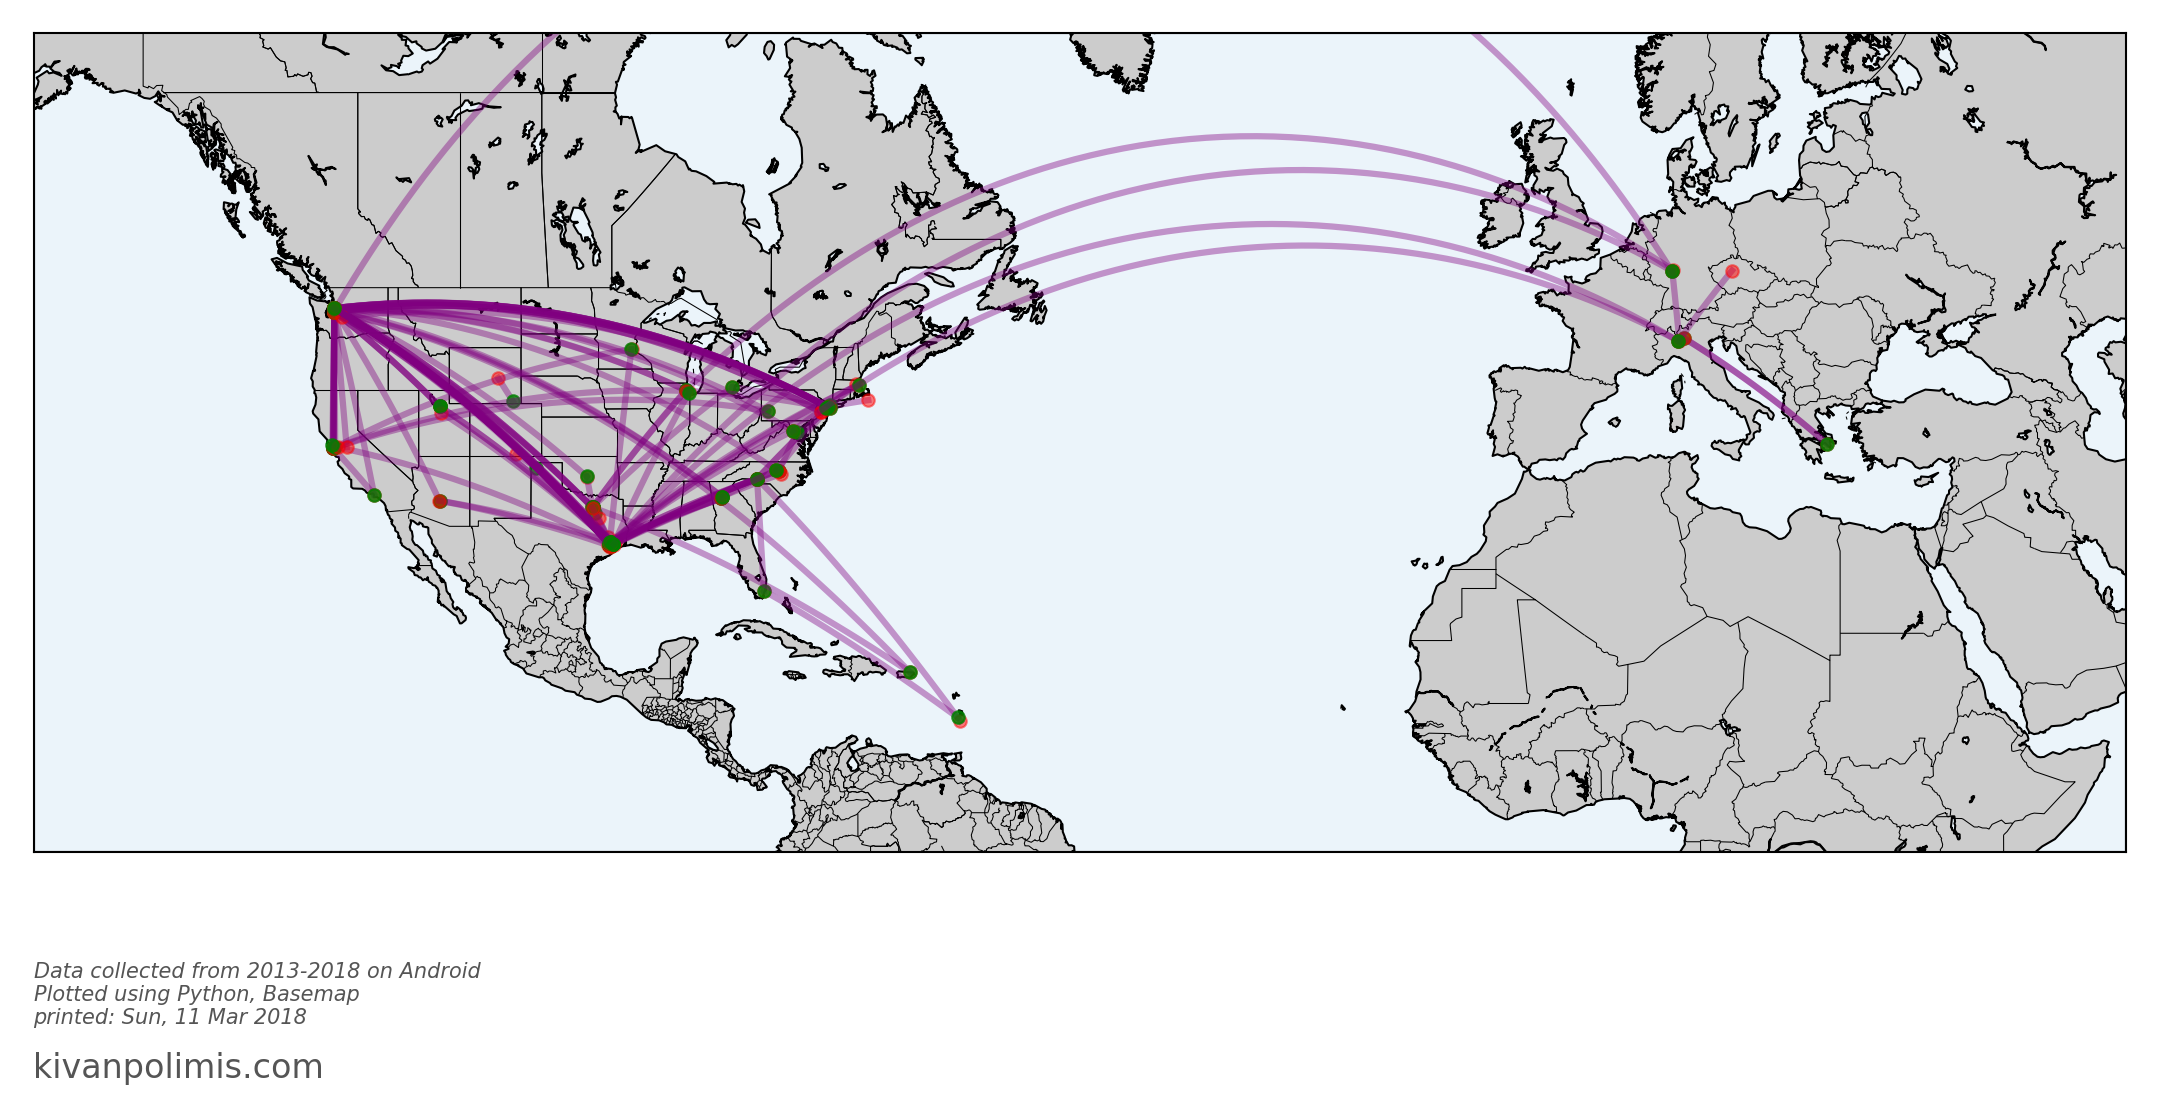

In [19]:
Image(filename='flights2018.png') 

## Potential future directions
* label airports 
    + can use [open flights dataset](https://openflights.org/data.html)
* add flight information (origin, destination, etc.) in the legend of each .png that is used to create the .gif

Download this [notebook](downloads/notebooks/gif_of_flights.ipynb), or see a static view [here](https://github.com/kpolimis/kpolimis.github.io/blob/master/downloads/notebooks/gif_of_flights.ipynb)

In [20]:
import sys
import time
print("System and module version information: \n")
print('Python version: \n{} \n'.format(sys.version_info))
print("last updated: {}".format(time.strftime("%a, %d %b %Y %H:%M", time.localtime())))

System and module version information: 

Python version: 
sys.version_info(major=2, minor=7, micro=14, releaselevel='final', serial=0) 

last updated: Sun, 11 Mar 2018 09:15
